# Python機器學習與深度學習入門 
## Q10-1 ：用RNN做情意分析
## by R07522717 林温雅

`Package`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, Dropout, LSTM
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
print(tf.test.is_gpu_available())

True


為求測試時每次data相同，固定seed=5  
因常出現的字可能為"I"、"you"、"this"、"movie"等字，和好評負評較無直接關係，跳過前20個字

In [310]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000, skip_top=20, seed=5)

In [311]:
x_train = sequence.pad_sequences(x_train, maxlen=180)
x_test = sequence.pad_sequences(x_test, maxlen=180)

## Testing vs. Validation
### 若針對"testing data"改參數，是否是對testing data的"overfitting"?

與R07522821許鐘元同學討論後，決定在訓練時，養成不偷看答案來調參數的習慣  
不將testing data當作validation data監控accuracy，因此將training data切2000筆出來當作validation data  
訓練model時監控這組data的accuracy，就比較沒有偷看答案的問題

In [312]:
x_valid = x_train[23000:]
y_valid = y_train[23000:]
x_train = x_train[:23000]
y_train = y_train[:23000]

In [313]:
N = 128
K = 64

In [314]:
model = Sequential() 
model.add(Embedding(10000, N))
model.add(LSTM(K, recurrent_dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.add(Dropout(0.1))
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_46 (Embedding)     (None, None, 128)         1280000   
_________________________________________________________________
lstm_45 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 65        
_________________________________________________________________
dropout_44 (Dropout)         (None, 1)                 0         
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [315]:
%%time
early_stopping = EarlyStopping('val_acc', patience=2, verbose=1)
model_history = model.fit(x_train, y_train, batch_size=512, epochs=30, 
                          validation_data = (x_valid, y_valid), verbose = 1,
                          shuffle = True, callbacks=[early_stopping])

Train on 23000 samples, validate on 2000 samples
Epoch 1/30
23000/23000 [==============================] - 18s 777us/step - loss: 1.3853 - acc: 0.6228 - val_loss: 0.4887 - val_acc: 0.8055
Epoch 2/30
23000/23000 [==============================] - 14s 610us/step - loss: 1.1763 - acc: 0.7757 - val_loss: 0.5242 - val_acc: 0.7360
Epoch 3/30
23000/23000 [==============================] - 14s 608us/step - loss: 1.1652 - acc: 0.7978 - val_loss: 0.3765 - val_acc: 0.8485
Epoch 4/30
23000/23000 [==============================] - 14s 610us/step - loss: 1.0609 - acc: 0.8440 - val_loss: 0.3781 - val_acc: 0.8490
Epoch 5/30
23000/23000 [==============================] - 14s 607us/step - loss: 1.0464 - acc: 0.8593 - val_loss: 0.3640 - val_acc: 0.8490
Epoch 6/30
23000/23000 [==============================] - 14s 609us/step - loss: 0.9972 - acc: 0.8726 - val_loss: 0.3569 - val_acc: 0.8595
Epoch 7/30
23000/23000 [==============================] - 14s 607us/step - loss: 0.9556 - acc: 0.8846 - val_loss: 0.3

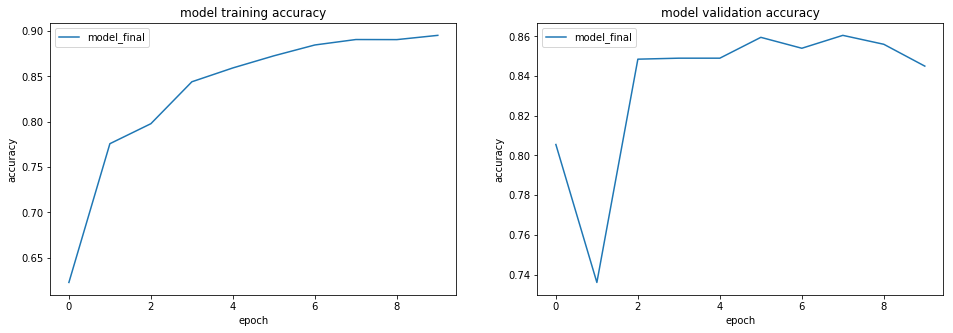

In [316]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1,2,1)
plt.plot(model_history.history["acc"])

plt.title("model training accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["model_final"], loc = "best")

ax2 = fig.add_subplot(1,2,2)
plt.plot(model_history.history["val_acc"])

plt.title("model validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["model_final"], loc = "best")

plt.show()

In [317]:
max_acc = max(model_history.history["acc"])
max_index = model_history.history["acc"].index(max_acc)
max_valacc = max(model_history.history["val_acc"])
max_valindex = model_history.history["val_acc"].index(max_valacc)
print(f'最高training accuracy： {max_acc}\n發生在epoch = {max_index}')
print(f'最高validation accuracy： {max_valacc}\n發生在epoch = {max_valindex}')

最高training accuracy： 0.8951739133544591
發生在epoch = 9
最高validation accuracy： 0.8604999952316285
發生在epoch = 7


In [319]:
score = model.evaluate(x_test, y_test, batch_size=128)
print("Loss: %f" %score[0])
print("testing accuracy: %f" %(score[1]*100))

25000/25000 [==============================] - 13s 509us/step
Loss: 0.393364
testing accuracy: 83.728000


試過許多配置都沒讓val_acc超過87%  
在Validation data下最高可以有86%左右的正確率，然而在Testing data下僅83.72%  

### [同場加映Keras官方範例](https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py)
Keras範例是直接將testing data當作validation data，或許在進行基本測試時不需太嚴謹對這兩者做出區分  
但我認為若要做泛用型的Model應當還是將這兩者分別清楚較佳

官方範例大概是81%左右之準確度

In [309]:
from __future__ import print_function
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/15
25000/25000 [==============================] - 141s 6ms/step - loss: 0.4575 - acc: 0.7842 - val_loss: 0.3919 - val_acc: 0.8272
Epoch 2/15
25000/25000 [==============================] - 137s 5ms/step - loss: 0.2974 - acc: 0.8795 - val_loss: 0.3919 - val_acc: 0.8244
Epoch 3/15
25000/25000 [==============================] - 138s 6ms/step - loss: 0.2184 - acc: 0.9165 - val_loss: 0.4252 - val_acc: 0.8203
Epoch 4/15
25000/25000 [==============================] - 138s 6ms/step - loss: 0.1514 - acc: 0.9428 - val_loss: 0.4616 - val_acc: 0.8286
Epoch 5/15
25000/25000 [==============================] - 138s 6ms/step - loss: 0.1080 - acc: 0.9612 - val_loss: 0.5302 - val_acc: 0.8254
Epoch 6/15
25000/25000 [==============================] - 138s 6ms/step - loss: 0.0761 - acc: